1. Load CIFAR10 dataset can be directly into you Python program using keras. (1)

In [1]:
import tensorflow as tf
from tensorflow import keras
#reference:https://keras.io/api/datasets/cifar10/
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()



170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


2. Assign the train and test datasets (1)


In [2]:
print(f"train: {x_train.shape}")
print(f"test: {x_test.shape}")

train: (50000, 32, 32, 3)
test: (10000, 32, 32, 3)


3. Visualize 100 images from the train dataset. (2)


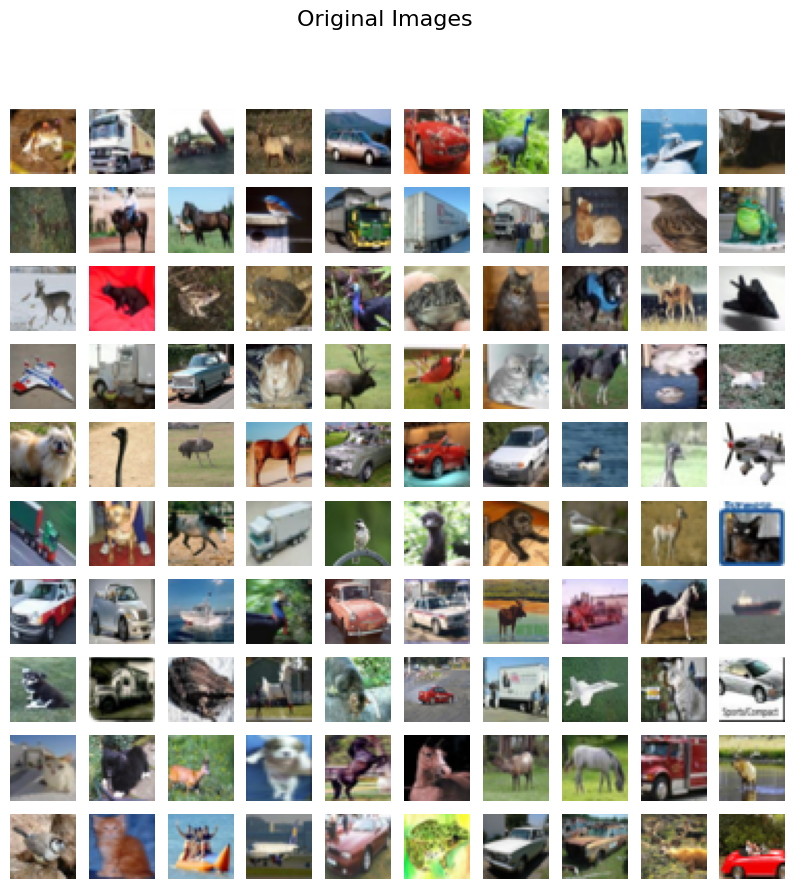

In [3]:
import matplotlib.pyplot as plt


def visualize_images(image, title, n_image=100):
    #size 10*10 for 100 images
    plt.figure(figsize=(10,10))
    plt.suptitle(title, fontsize=16)
    for i in range(n_image):
        plt.subplot(10, 10, i+1)
        plt.imshow(image[i])
        #no axis label needed
        plt.axis('off')
    plt.show()

#first 100
visualize_images(x_train[:100], 'Original Images')

4. Scale the images (if necessary) (1)


In [4]:
#the pictures in the dataset are stored in uint8, but we are expecting float for accuracy as we normalize the values.
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

5. Add noise to the images (for both train and test partitions) (1)


In [5]:
import numpy as np
#reference https://stackoverflow.com/questions/22937589/how-to-add-noise-gaussian-salt-and-pepper-etc-to-image-in-python-with-opencv
def add_noise(image, noise_factor=0.000001**(0.00005**0.22)):
    #use normal [-1,1] distribution with noise_factor
    noisy = np.random.normal(loc=0.0, scale=1.0, size=image.shape) * noise_factor
    noisy_images = image + noisy
    #clip image pixel value to 0-1 to keep effectiveness
    noisy_images = np.clip(noisy_images, 0., 1.)
    return noisy_images

x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

6. Visualize 100 noisy images (from the train partition) (2)


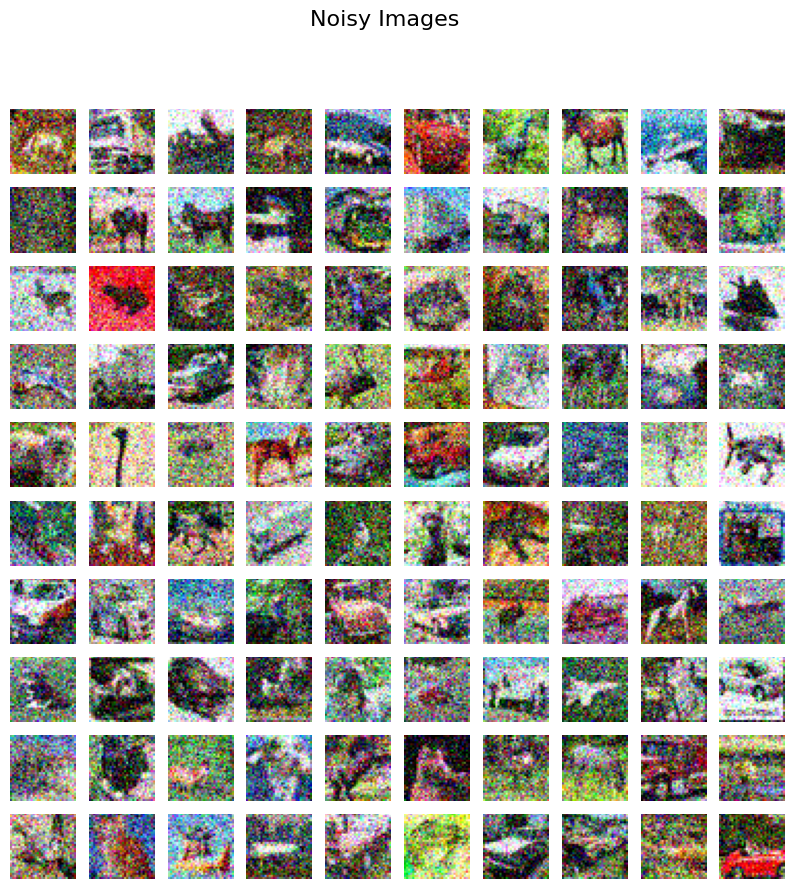

In [6]:
visualize_images(x_train_noisy[:100], 'Noisy Images')

7. Now build a keras convolutional autoencoder to denoise the images. Use at least 4 convolutional layers, 2 maxpooling layers, 2 upscaling layers. (3)

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

#image shape 32*32 with RGB of 3

# Encoder
model = keras.models.Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same',input_shape=(32, 32, 3))) #32*32*64
model.add(MaxPooling2D(pool_size=(2, 2), padding='same')) #16*16*64
model.add(Conv2D(64, (3, 3), activation='relu', padding='same')) #16*16*64
model.add(MaxPooling2D(pool_size=(2, 2), padding='same')) #8*8*64
model.add(Conv2D(128, (3, 3), activation='relu', padding='same')) #8*8*128
model.add(MaxPooling2D(pool_size=(2, 2), padding='same')) #4*4*128
model.add(Conv2D(128, (3, 3), activation='relu', padding='same')) #4*4*128
model.add(MaxPooling2D(pool_size=(2, 2), padding='same')) #2*2*128

# Decoder
model.add(Conv2D(128, (3, 3), activation='relu', padding='same')) #2*2*128
model.add(UpSampling2D((2, 2)))  #4*4*128
model.add(Conv2D(128, (3, 3), activation='relu', padding='same')) #4*4*128
model.add(UpSampling2D((2, 2)))  #8*8*128
model.add(Conv2D(64, (3, 3), activation='relu', padding='same')) #8*8*64
model.add(UpSampling2D((2, 2)))  #16*16*64
model.add(Conv2D(64, (3, 3), activation='relu', padding='same')) #16*16*64
model.add(UpSampling2D((2, 2)))  #32*32*64

#back to 3 channels output
model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))  # output shape: 32*32*3

model.compile(optimizer='adam',loss='mse')
model. summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 2, 2, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 3)           │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 667,779 (2.55 MB)

 Trainable params: 667,779 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

8. Train the model using appropriate hyperparameters (3)


In [8]:
history = model.fit(
    x_train_noisy,     # input: noisy images
    x_train,           # output: original images
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)

Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 0.0370 - val_loss: 0.0166
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0160 - val_loss: 0.0136
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0133 - val_loss: 0.0120
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0120 - val_loss: 0.0123
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.0112 - val_loss: 0.0106
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0106 - val_loss: 0.0103
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0102 - val_loss: 0.0102
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0097 - val_loss: 0.0098
Epoch 9/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0095 - val_loss: 0.0092
Epoch 10/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.0092 - val_loss: 0.0093
Epoch 11/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.0090 - val_loss: 0.0089
Epoch 12/50
391/391 ━━━━━━━━━━━━━━━

9. Now denoise 50 images (from the test partition). Visualize the noisy and denoised versions of each image. (4)


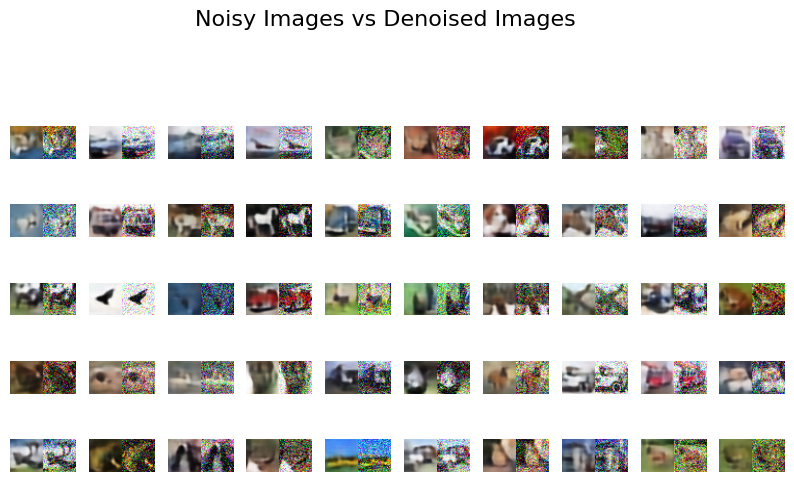

In [24]:
def combine_noisy_denoised(noisy_images, denoised_images):
    combined_images = []
    for i in range(len(noisy_images)):
        #stack denoised with noisy images
        #reference https://numpy.org/doc/stable/reference/generated/numpy.hstack.html
        combined = np.hstack((denoised_images[i], noisy_images[i]))
        combined_images.append(combined)
    return np.array(combined_images)

combined_images = combine_noisy_denoised(x_test_noisy[:50], denoised_images[:50])

visualize_images(combined_images[:50], 'Noisy Images vs Denoised Images', 50)

10. Then visualize just three noisy and denoised versions of three images (2)


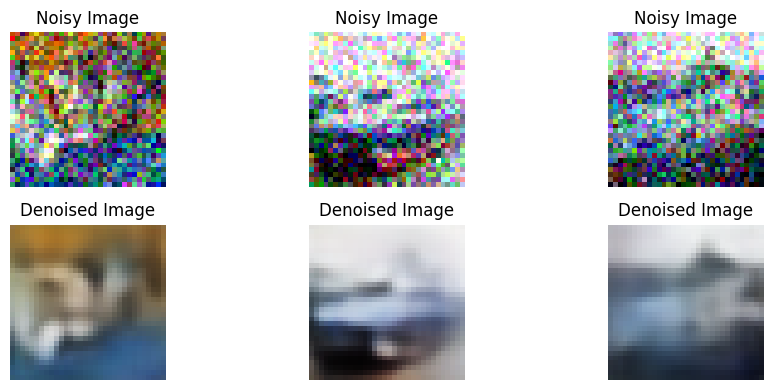

In [27]:
# visualize_images(combined_images[:3], 'Noisy Images vs Denoised Images', 3)

def visualize_noisy_denoised(noisy_image, denoised_image):
    plt.figure(figsize=(10, 4))

    for i in range(3):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(noisy_image[i])
        plt.title("Noisy Image")
        plt.axis('off')

        ax = plt.subplot(2, 3, i + 1 + 3)
        plt.imshow(denoised_image[i])
        plt.title("Denoised Image")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_noisy_denoised(x_test_noisy[:3], denoised_images[:3])